# A Fine Windy Day Challenge: HackerEarth Machine Learning Challenge

Task: To predict power that is generated based on other features available

#### Downloading Dataset and unzipping

In [6]:
!unzip 949ca43ea68511eb.zip

Archive:  949ca43ea68511eb.zip
   creating: dataset/
  inflating: dataset/train.csv       
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        


#### Install necessary packages

In [7]:
# Use seaborn for pairplot
!pip install -q seaborn

#### Importing necessary packages

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


#### Util functions

In [9]:
# Util Functions
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

#### Importing datasets

In [10]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
submission_df = pd.read_csv('dataset/sample_submission.csv')
train_df.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


#### EDA of Dataset

In [11]:
test_df.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440


In [12]:
submission_df.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,6.766521
1,WM_698,2018-11-05 10:13:20,5.966275
2,WM_39146,2019-09-14 14:03:20,2.874342
3,WM_6757,2018-12-25 15:33:20,14.851089
4,WM_21521,2019-05-04 03:13:20,3.519074


In [13]:
submission_df = submission_df[0:0]
submission_df['tracking_id'] = test_df['tracking_id']
submission_df['datetime'] = test_df['datetime']

submission_df.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_19817,2019-04-17 08:53:20,NaN
1,WM_18723,2019-03-30 07:43:20,NaN
2,WM_34552,2019-08-10 11:33:20,NaN
3,WM_28570,2019-06-26 03:53:20,NaN
4,WM_36934,2019-08-27 16:43:20,NaN


In [14]:
train_df.drop(["tracking_id","datetime"],axis=1,inplace=True)
test_df.drop(["tracking_id","datetime"],axis=1,inplace=True)

In [15]:
train_df.shape

(28200, 20)

In [16]:
train_df.isna().sum()

wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

#### Dropping rows that dont have y label

In [17]:
train_df = train_df[train_df['windmill_generated_power(kW/h)'].notna()]

#### Checking null rows

In [18]:
train_df.isna().sum()

wind_speed(m/s)                    271
atmospheric_temperature(°C)       3422
shaft_temperature(°C)                2
blades_angle(°)                    212
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2690
area_temperature(°C)                 0
windmill_body_temperature(°C)     2352
wind_direction(°)                 5058
resistance(ohm)                      1
rotor_torque(N-m)                  567
turbine_status                    1747
cloud_level                        272
blade_length(m)                   5057
blade_breadth(m)                     0
windmill_height(m)                 538
windmill_generated_power(kW/h)       0
dtype: int64

#### Categorical to numeric coding

In [19]:
# turbine_status	cloud_level

train_df['turbine_status'].unique()

array(['BA', 'A2', 'ABC', 'AAA', 'BD', 'AC', 'BB', 'BCB', 'B', 'AB', nan,
       'B2', 'BBB', 'A', 'D'], dtype=object)

In [20]:
turbine_mapping_dict = {}
turbine_list = train_df['turbine_status'].unique().tolist()
turbine_mapping_dict[turbine_list[10]] = turbine_list[10]
turbine_list.pop(10)
for i in range(len(turbine_list)):
  turbine_mapping_dict[turbine_list[i]] = i+1

turbine_mapping_dict

{'A': 13,
 'A2': 2,
 'AAA': 4,
 'AB': 10,
 'ABC': 3,
 'AC': 6,
 'B': 9,
 'B2': 11,
 'BA': 1,
 'BB': 7,
 'BBB': 12,
 'BCB': 8,
 'BD': 5,
 'D': 14,
 nan: nan}

In [21]:
train_df['turbine_status'] = train_df['turbine_status'].map(turbine_mapping_dict)
test_df['turbine_status'] = test_df['turbine_status'].map(turbine_mapping_dict)

In [22]:
train_df['cloud_level'].unique()

array(['Medium', nan, 'Low', 'Extremely Low'], dtype=object)

In [23]:
cloud_level_mapping_dict = {}

cloud_list = train_df['cloud_level'].unique().tolist()
cloud_level_mapping_dict[cloud_list[1]] = cloud_list[1]
cloud_list.pop(1)
for i in range(len(cloud_list)):
  cloud_level_mapping_dict[cloud_list[i]] = i+1

cloud_level_mapping_dict

{'Extremely Low': 3, 'Low': 2, 'Medium': 1, nan: nan}

In [24]:
train_df['cloud_level'] = train_df['cloud_level'].map(cloud_level_mapping_dict)
test_df['cloud_level'] = test_df['cloud_level'].map(cloud_level_mapping_dict)

In [25]:
train_df.head()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,1.0,1.0,2.217542,0.314065,24.281689,6.766521
1,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,2.0,1.0,4.210346,0.448494,27.262139,5.966275
2,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,3.0,1.0,2.719475,0.302321,27.366127,2.874342
3,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,3.0,NaN,4.857385,0.367140,24.287767,14.851089
4,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,4.0,1.0,NaN,0.453374,27.971650,3.519074


In [26]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind_speed(m/s),27722.0,69.032217,76.328773,-4.962110e+02,20.874363,93.298798,95.268345,6.014557e+02
atmospheric_temperature(°C),24571.0,0.371184,44.282582,-9.900000e+01,7.945627,16.105033,23.685345,8.021744e+01
shaft_temperature(°C),27991.0,40.078707,27.196820,-9.900000e+01,41.633454,43.684350,45.672836,1.698205e+02
blades_angle(°),27781.0,-9.656611,47.918442,-1.462595e+02,-1.197580,-0.496836,5.483500,1.659321e+02
gearbox_temperature(°C),27992.0,41.003447,43.682029,-2.449741e+02,40.555872,43.219198,45.874781,9.990000e+02
engine_temperature(°C),27981.0,42.609963,6.131895,3.167151e+00,41.911875,43.525221,45.169599,5.000000e+01
motor_torque(N-m),27969.0,1710.444006,826.950553,5.000000e+02,870.298241,2031.627043,2461.047836,3.000000e+03
generator_temperature(°C),27981.0,65.014574,19.810115,3.389378e+01,41.195203,70.718938,78.923776,1.000000e+02
atmospheric_pressure(Pascal),25303.0,53048.942126,187420.927920,-1.188624e+06,16793.129156,18187.487632,118087.881568,1.272552e+06
area_temperature(°C),27993.0,32.728987,7.703850,-3.000000e+01,27.311681,32.592784,38.213333,5.500000e+01


In [27]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('windmill_generated_power(kW/h)')
test_labels = [0 for i in range(test_df.shape[0])] #fake data

In [28]:
train_labels = np.array(train_labels)

In [29]:
# To calculate mean use imputer class
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(np.array(train_features))
  
train_features = imputer.transform(train_features)
test_features = imputer.transform(test_features)

print(train_features)

[[ 94.82002337 -99.          41.72301901 ...   2.21754164   0.31406484
   24.28168894]
 [241.83273424  27.76478479 -99.         ...   4.2103463    0.44849442
   27.2621387 ]
 [ 95.48472432   0.37118411  41.85547319 ...   2.71947498   0.302321
   27.36612718]
 ...
 [ 94.16046347  28.6742957   45.00421329 ...   2.24876171   0.38026434
   28.53384966]
 [ 95.43037721  26.56025356  48.03262438 ...   3.00185467   0.34644747
   47.74726911]
 [ 43.55835211  18.72123086   9.22020818 ...   2.24876171   0.38885471
   24.12540827]]


In [30]:
normalizer = preprocessing.Normalization()

In [31]:
normalizer.adapt(train_features)

In [32]:
print(normalizer.mean.numpy())

[ 6.9032288e+01  3.7118429e-01  4.0078770e+01 -9.6566048e+00
  4.1003448e+01  4.2609966e+01  1.7104445e+03  6.5014549e+01
  5.3048965e+04  3.2729019e+01  2.0767244e+01  3.0672156e+02
  1.5754417e+03  2.5848269e+01  7.5278530e+00  1.5202560e+00
  2.2487631e+00  3.9724669e-01  2.5883698e+01]


In [126]:
# [i for i in train_labels if i<2]

In [158]:
def mapping_to_target_range(x, target_min=1, target_max=20) :
    x02 = tf.keras.backend.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min


linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(64, activation='elu',
    #              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(64, activation='elu',
    #              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(32, activation='elu',
    #              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation=mapping_to_target_range )

])

linear_model.compile(
    optimizer= tf.optimizers.Adam(learning_rate=0.01), #tf.keras.optimizers.RMSprop(0.001),
    loss="mean_squared_error", # mean_absolute_error,"mean_squared_error"
    ) 

linear_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 19)                39        
_________________________________________________________________
dense_92 (Dense)             (None, 64)                1280      
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 33        
Total params: 3,432
Trainable params: 3,393
Non-trainable params: 39
_________________________________________________________________


In [159]:
linear_model.predict(train_features[:10])

array([[4.4372163],
       [2.815877 ],
       [9.785452 ],
       [3.0539074],
       [4.033164 ],
       [4.95146  ],
       [3.4932487],
       [6.82782  ],
       [2.2253675],
       [3.9257998]], dtype=float32)

In [160]:
%%time
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0001)

history = linear_model.fit(
    train_features, train_labels, 
    epochs=epochs,
    # suppress logging
    verbose=1,
    batch_size=512,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[callback,reduce_lr])

Epoch 1/500
44/44 [==============================] - 1s 7ms/step - loss: 5.4034 - val_loss: 2.8985
Epoch 2/500
44/44 [==============================] - 0s 4ms/step - loss: 2.7223 - val_loss: 1.9081
Epoch 3/500
44/44 [==============================] - 0s 4ms/step - loss: 2.0300 - val_loss: 1.5646
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 1.7801 - val_loss: 1.4966
Epoch 5/500
44/44 [==============================] - 0s 4ms/step - loss: 1.5892 - val_loss: 1.2802
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 1.4516 - val_loss: 1.1405
Epoch 7/500
44/44 [==============================] - 0s 4ms/step - loss: 1.2874 - val_loss: 1.0153
Epoch 8/500
44/44 [==============================] - 0s 3ms/step - loss: 1.1152 - val_loss: 0.9549
Epoch 9/500
44/44 [==============================] - 0s 3ms/step - loss: 1.0468 - val_loss: 0.9335
Epoch 10/500
44/44 [==============================] - 0s 4ms/step - loss: 0.9806 - val_loss: 1.0813
Epoch 11/

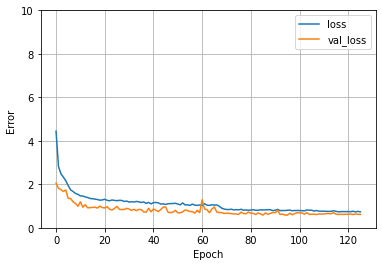

In [151]:
plot_loss(history)

Loss with RMSProp (lr = 0.0001) is 
Train loss 0.35617437958717346 and validation loss 0.3741430938243866

Loss with Adam (lr = 0.01) is Train loss 0.33599042892456055 and validation loss 0.38122525811195374

In [131]:
print(f'Train loss {history.history["loss"][-1]} and validation loss {history.history["val_loss"][-1]}')

Train loss 0.19344621896743774 and validation loss 0.39341339468955994


In [132]:
preds = linear_model.predict(test_features)

In [133]:
submission_df.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_19817,2019-04-17 08:53:20,2.739417
1,WM_18723,2019-03-30 07:43:20,2.560947
2,WM_34552,2019-08-10 11:33:20,3.002323
3,WM_28570,2019-06-26 03:53:20,11.051835
4,WM_36934,2019-08-27 16:43:20,3.533112


In [134]:
submission_df['windmill_generated_power(kW/h)'] = preds

submission_df.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_19817,2019-04-17 08:53:20,2.625036
1,WM_18723,2019-03-30 07:43:20,2.722383
2,WM_34552,2019-08-10 11:33:20,3.409704
3,WM_28570,2019-06-26 03:53:20,6.967700
4,WM_36934,2019-08-27 16:43:20,4.058773


In [136]:
submission_df.to_csv('submission.csv',index=False)